# Detection of shelters on a drone image of a refugee camp with YOLOv8

## Libs 

### Library installation
Yolov8 doesn't work with all Pytorch install. I had to downgrade my version because the Yolo training process was "stuck" because of the version. Here is the Pytoch install packages who worked for me: 

!pip install ultralytics==8.1.17

!pip install torch==1.10.0+cu102 torchvision==0.11.1+cu102 torchaudio==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html

!pip install geopandas

### Import libs

In [13]:
# Importing standard libraries
import os
import gc

# Importing data manipulation and geospatial libraries
import pandas as pd
import geopandas as gpd

# Importing image processing and computer vision libraries
import cv2
import numpy as np
from PIL import Image

# Importing deep learning frameworks
import torch

# Importing raster processing libraries
import rasterio
from rasterio.transform import xy
from rasterio.plot import show

# Importing geometry utilities
from shapely.geometry import Polygon, box, Point

# Importing display utilities for Jupyter Notebooks
from IPython.display import display

# Importing libraries for object detection
import ultralytics

# Importing visualization libraries
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

# Importing SAHI for sliced object detection
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction
from sahi.utils.cv import read_image_as_pil

# Print Ultralytics version and perform checks
print(ultralytics.__version__)
ultralytics.checks()

Ultralytics YOLOv8.2.57  Python-3.9.18 torch-1.10.0+cu102 CUDA:0 (NVIDIA T1200 Laptop GPU, 4096MiB)
Setup complete  (20 CPUs, 47.7 GB RAM, 112.0/127.0 GB disk)


In [14]:
# Print CUDA
cuda_version = torch.version.cuda
print("CUDA Version:", cuda_version)

# Empty cuda cache
torch.cuda.empty_cache()
!nvidia-smi

CUDA Version: 10.2
Mon Jul 22 23:30:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 538.18                 Driver Version: 538.18       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA T1200 Laptop GPU      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P8               3W /  30W |    997MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+------

## Functions 

In [15]:
def get_epsg(tif_file):
    """
    Retrieves the EPSG code from a GeoTIFF file's coordinate reference system (CRS).

    Parameters:
    tif_file (str): The file path to the GeoTIFF image.

    Returns:
    int or None: The EPSG code if found, otherwise None.
    
    Notes:
    - If the EPSG code is not found or is unknown, the function prints a message and returns None.
    """
    with rasterio.open(tif_file) as src:
        crs = src.crs
    
    if 'init' not in crs or crs['init'].lower() == 'unknown':
        print('EPSG code not found.')
        return None

    epsg_code = int(crs['init'][5:])  # Extracting the EPSG code number
    return epsg_code
   
def get_corners_coordinates(geotiff_path):
    """
    Extracts the coordinates of the four corners of a GeoTIFF image.

    Parameters:
    geotiff_path (str): The file path to the GeoTIFF image.

    Returns:
    list of tuple: A list of tuples containing the coordinates of the four corners
                   in the following order:
                   - Top Left (ul_x, ul_y)
                   - Top Right (ur_x, ur_y)
                   - Bottom Left (ll_x, ll_y)
                   - Bottom Right (lr_x, lr_y)
    """
    with rasterio.open(geotiff_path) as src:
        height = src.height  # number of rows
        width = src.width   # number of columns

        transform = src.transform
        
        # Calculate coordinates for each corner
        ul_x, ul_y = transform * (0, 0)  # Top Left
        ur_x, ur_y = transform * (width, 0)  # Top Right
        ll_x, ll_y = transform * (0, height)  # Bottom Left
        lr_x, lr_y = transform * (width, height)  # Bottom Right

    return [(ul_x, ul_y), (ur_x, ur_y), (ll_x, ll_y), (lr_x, lr_y)]
   
def create_and_project_gdf_polygon(object_prediction_list, image, epsg, raster_top_right, raster_bottom_left):

    """This function create_and_project_gdf_polygon takes an object_prediction_list, an input image, and two sets of geographical raster coordinates as inputs. It processes these inputs to generate projected geometries (Polygons) from detected objects within the images using their corresponding bounding boxes, and returns them as a GeoDataFrame. Here's a breakdown of its functionality based on the provided code snippet:

    Gets the dimensions (width and height) of the input image.
    Initializes an empty list polygons to hold information about each generated polygon.
    Iterates through each object prediction in the object_prediction_list.
        Extracts the bounding box coordinates.
        Calculates the respective projective X and Y coordinates using the original bounding box values, transformed by the ratio between the image size and the geographic raster range.
        Creates four points representing the corners of the bounding box using the calculated projections.
        Forms a polygon using these points.
        Appends this polygon data, including confidence scores and category details, to the polygons list.
    Converts the list of dictionaries containing polygonal geometry, confidence scores, and category info into a GeoDataFrame, specifying a source coordinate reference system (CRS).
    Returns the resulting GeoDataFrame of projected polygons.

    """
    # Get the dimensions of the image
    width, height = image.size

    # List to store polygons
    polygons = []

    # Iterate over inference results
    for obj in object_prediction_list:
        # Extracting bounding box coordinates
        bounding_box = obj.bbox

        # Extract bounding box YOLO coordinates 
        minx, miny, maxx, maxy = bounding_box.minx, bounding_box.miny, bounding_box.maxx, bounding_box.maxy

        # Unpack raster coordinates 
        ((tile_x2, tile_y2), (tile_x1, tile_y1)) = raster_top_right, raster_bottom_left

        # Transformation to projection
        minx_proj = (minx / width) * (tile_x2 - tile_x1) + tile_x1  # MinX
        miny_proj = (1 - miny / height) * (tile_y2 - tile_y1) + tile_y1  # MinY
        maxx_proj = (maxx / width) * (tile_x2 - tile_x1) + tile_x1  # MaxX
        maxy_proj = (1 - maxy / height) * (tile_y2 - tile_y1) + tile_y1  # MaxY
    
        # Creating Points for corners of the Bounding Box
        point1 = Point(minx_proj, miny_proj)  # Bottom-left corner
        point2 = Point(maxx_proj, miny_proj)  # Bottom-right corner
        point3 = Point(maxx_proj, maxy_proj)  # Top-right corner
        point4 = Point(minx_proj, maxy_proj)  # Top-left corner

        # Creating Polygon
        polygon = Polygon([point1, point2, point3, point4])

        # Append polygon along with other attributes into the list
        polygons.append({
            'geometry': polygon, 
            'bbox': [minx, miny, maxx, maxy],
            'bbox_proj': [minx_proj, miny_proj, maxx_proj, maxy_proj],
            'bbox_minx' : minx_proj,
            'bbox_miny' : miny_proj,
            'bbox_maxx' : maxx_proj,
            'bbox_maxy' : maxy_proj,
            'confidence': obj.score.value,
            'cat_name': obj.category.name,
            'cat_id': obj.category.id
        })

    # Convert list of dictionaries to GeoDataFrame
    gdf = gpd.GeoDataFrame(polygons,crs=epsg)

    return gdf

def filter_classes_by_surface(gdf_polygon, cat_name, min_area_msq=3, max_area_msq=50):
    """
    Filters polygons in a GeoDataFrame based on category names and area constraints.
    
    Parameters:
    gdf_polygon (GeoDataFrame): Input GeoDataFrame containing polygons.
    cat_name (list): List of category names to filter by.
    min_area_msq (float): Minimum area threshold for filtering (default is 3 m²).
    max_area_msq (float): Maximum area threshold for filtering (default is 50 m²).
    
    Returns:
    GeoDataFrame: Filtered GeoDataFrame.
    """
    
    # Print the number of original polygons
    before_filter = len(gdf_polygon)
    print("Number of original polygons:", before_filter)

    # Reproject and calculate area
    gdf_polygon = gdf_polygon.to_crs(epsg=3857)
    gdf_polygon['area'] = gdf_polygon.geometry.area
    gdf_polygon = gdf_polygon.to_crs(epsg=EPSG_SOURCE)

    # Filter by category
    subset_polygon = gdf_polygon[gdf_polygon['cat_name'].isin(cat_name)]
    print('Considered categories:', subset_polygon['cat_name'].unique())

    # Apply area filtering
    subset_polygon = subset_polygon[(subset_polygon['area'] <= max_area_msq) &
                                    (subset_polygon['area'] >= min_area_msq)]

    # Combine filtered subset back with untouched categories
    gdf_polygon = pd.concat([gdf_polygon[~gdf_polygon['cat_name'].isin(cat_name)], subset_polygon])

    # Print results
    print("Number of remaining polygons after filtering:", len(gdf_polygon))
    print("Number of filtered polygons:", before_filter - len(gdf_polygon))
    print("___________________________________________________________")
    return gdf_polygon

def non_max_suppression_fast(boxes, iou_threshold=0.4):
    """
    Applies non-maximum suppression to a list of bounding boxes.

    Args:
    boxes (array-like): List or array of bounding boxes with coordinates [x1, y1, x2, y2].
    iou_threshold (float): Intersection over Union (IoU) threshold for suppression.

    Returns:
    np.ndarray: Array of retained bounding boxes after suppression, in integer format.

    Sources:
    - https://pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
    - Malisiewicz et al.: https://www.computervisionblog.com/2011/08/blazing-fast-nmsm-from-exemplar-svm.html
    """
    # Convert boxes to a NumPy array if it's not already one
    if isinstance(boxes, list):
        boxes = np.array(boxes)

    # If there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # Initialize the list of picked indexes
    pick = []
    
    # Grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    
    # Compute the area of the bounding boxes
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    
    # Sort the bounding boxes by the bottom-right y-coordinate
    idxs = np.argsort(y2)
    
    # Loop while some indexes still remain in the index list
    while len(idxs) > 0:
        # Grab the last index and add it to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        
        # Find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        
        # Compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        
        # Compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        
        # Delete all indexes from the index list that have overlap greater than the threshold
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > iou_threshold)[0])))

    # Return only the bounding boxes that were picked, using the integer data type
    return boxes[pick].astype("int")

## Parameters

In [16]:
# Replace 'SOURCE_IMAGE_PATH' with your actual GeoTIFF path
SOURCE_IMAGE_PATH = r".\Raster\COD_Elohim_DJIMM3P.tif"

# Object detection parms
best_model = r'.\COD_MOZ_TCD_nano_12apr2024_Google_Colab\train\weights\best.pt'
confidence_threshold=0.4

# True to plot it below. Set to Flase to save some RAM
plot_raster = True

## Load model

In [17]:
# Initiate detection model
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov8',
    model_path=best_model,
    confidence_threshold=confidence_threshold,
    device="cuda:0"
)

## Load raster
Here below we will load the raster and convert it into a numpy array. To save some memory, clip the raster to the area of interest only.
A function will extract the raster corner coordinates. It will be useful to reproject the bboxes extracet by Yolo.

In [18]:
# Get image epsg
EPSG_SOURCE = get_epsg(SOURCE_IMAGE_PATH)
print("Raster EPSG:",EPSG_SOURCE)

# Read the raster with PIL
image = read_image_as_pil(SOURCE_IMAGE_PATH)

# Extract coordinates corners
_, raster_top_right, raster_bottom_left, _ = get_corners_coordinates(SOURCE_IMAGE_PATH)
print("Bottom Left Coordinate:", raster_bottom_left)
print("Top Right Coordinate:", raster_top_right)

if plot_raster:
    print("_________________________________")
    plt.figure(figsize=(10, 8))
    plt.imshow(image)  
    plt.title(os.path.basename(SOURCE_IMAGE_PATH))
    plt.show()

Raster EPSG: 4326
Bottom Left Coordinate: (29.121686809701252, -1.615781422055621)
Top Right Coordinate: (29.125148176302254, -1.611600683403621)
_________________________________


## Run inference on raster with SAHI

Slicing Aided Hyper Inference (SAHI) is a lightweight vision library for performing large scale object detection & instance segmentation.

More information at :

*  https://github.com/obss/sahi
*  https://blog.ml6.eu/how-to-detect-small-objects-in-very-large-images-70234bab0f98

 ![SAHI](https://raw.githubusercontent.com/obss/sahi/main/resources/sliced_inference.gif)


### Running the inference
In this section, we perform inference using the SAHI (Slicing Aided Hyper Inference) method on a drone image of a camp. This technique allows for efficient processing of large images by slicing them into manageable parts. Depending on your GPU memory, adjust the slice size. It's also important to set the overlap between slices to a value greater than the size of the objects we want to detect to ensure complete coverage. On the other and, a larger overlap requests more ressources.

In [19]:
# Run inference with SAHI
result = get_sliced_prediction(
        image,
        detection_model,
        slice_height = 2048,
        slice_width = 2048,
        overlap_height_ratio = 0.4,
        overlap_width_ratio = 0.4
    )

Performing prediction on 42 number of slices.


### Extract the prediction Results to a GeoDataFrame

From the prediction results, we will extract all bounding boxes (bboxes) defined by xmin, ymin, xmax, and ymax, based on the image with coordinates starting at x = 0 and y = 0. 
These will then be reprojected to the source projection to obtain geographic coordinates for use in GIS software. We will also extract other information, including category name, category ID, and confidence, which are included in the prediction results.


In [20]:
# Extract from prediction list to geodataframe
gdf_polygon = create_and_project_gdf_polygon(result.object_prediction_list,
                                             image,
                                             EPSG_SOURCE,
                                             raster_top_right, 
                                             raster_bottom_left
                                            )
# Print the gdf size and gdf head
print(gdf_polygon.shape)
gdf_polygon.head()

(1653, 10)


geometry  \
0  POLYGON ((29.12382 -1.61160, 29.12404 -1.61160...   
1  POLYGON ((29.12381 -1.61439, 29.12385 -1.61439...   
2  POLYGON ((29.12343 -1.61289, 29.12347 -1.61289...   
3  POLYGON ((29.12303 -1.61347, 29.12308 -1.61347...   
4  POLYGON ((29.12393 -1.61311, 29.12398 -1.61311...   

                                                bbox  \
0  [4336.610107421875, 0, 4791.459716796875, 343....   
1  [4322.4317626953125, 5650.041748046875, 4411.2...   
2  [3542.6614990234375, 2617.8342895507812, 3636....   
3  [2742.1453857421875, 3774.1284942626953, 2828....   
4  [4559.686340332031, 3054.4521484375, 4662.3723...   

                                           bbox_proj  bbox_minx  bbox_miny  \
0  [29.123816878863646, -1.611600683403621, 29.12...  29.123817  -1.611601   
1  [29.12380991470175, -1.61439346513943, 29.1238...  29.123810  -1.614393   
2  [29.12342690480433, -1.6128946631859402, 29.12...  29.123427  -1.612895   
3  [29.12303370489826, -1.6134662124735641, 29.12...  29.123034  -1.613466   
4  [29.123926450116958, -1.6131104807738808, 29.1...  29.123926  -1.613110   

   bbox_maxx  bbox_maxy  confidence  cat_name  cat_id  
0  29.124040  -1.611770    0.616964  building       0  
1  29.123854  -1.614435    0.857086       car       1  
2  29.123473  -1.612948    0.807818       car       1  
3  29.123076  -1.613512    0.783185       car       1  
4  29.123977  -1.613147    0.706166       car       1

## Filtering

In [21]:
# Get a quick overview of each ccategory
gdf_polygon['cat_name'].value_counts()

cat_name
shelter informal            1500
dwelling                      85
under construction            43
latrine plastic sheeting      10
car                            6
umbrella                       6
building                       1
latrine                        1
tent                           1
Name: count, dtype: int64

### Area filtering
This section includes a function to filter groups of categories based on their surface areas, using specified minimum and maximum thresholds. The aim is to reduce the number of false positives. For example, a shelter rarely has a surface area above 50m². The surface filtering parameters are based on local knowledge and may vary from camp to camp.

In [22]:
# Filter by category
gdf_polygon = filter_classes_by_surface(gdf_polygon, 
                                        ['shelter informal','under construction'], 
                                        min_area_msq=4, 
                                        max_area_msq=50)
gdf_polygon = filter_classes_by_surface(gdf_polygon, 
                                        ['car'], 
                                        min_area_msq=3, 
                                        max_area_msq=10)
gdf_polygon = filter_classes_by_surface(gdf_polygon, 
                                        ['building','dwelling'], 
                                        min_area_msq=10, 
                                        max_area_msq=100)
gdf_polygon = filter_classes_by_surface(gdf_polygon, 
                                        ['latrine'], 
                                        min_area_msq=5, 
                                        max_area_msq=20)
gdf_polygon = filter_classes_by_surface(gdf_polygon, 
                                        ['latrine plastic sheeting'], 
                                        min_area_msq=0.5, 
                                        max_area_msq=8)

Number of original polygons: 1653
Considered categories: ['shelter informal' 'under construction']
Number of remaining polygons after filtering: 1637
Number of filtered polygons: 16
___________________________________________________________
Number of original polygons: 1637
Considered categories: ['car']
Number of remaining polygons after filtering: 1631
Number of filtered polygons: 6
___________________________________________________________
Number of original polygons: 1631
Considered categories: ['building' 'dwelling']
Number of remaining polygons after filtering: 1622
Number of filtered polygons: 9
___________________________________________________________
Number of original polygons: 1622
Considered categories: ['latrine']
Number of remaining polygons after filtering: 1621
Number of filtered polygons: 1
___________________________________________________________
Number of original polygons: 1621
Considered categories: ['latrine plastic sheeting']
Number of remaining polygons af

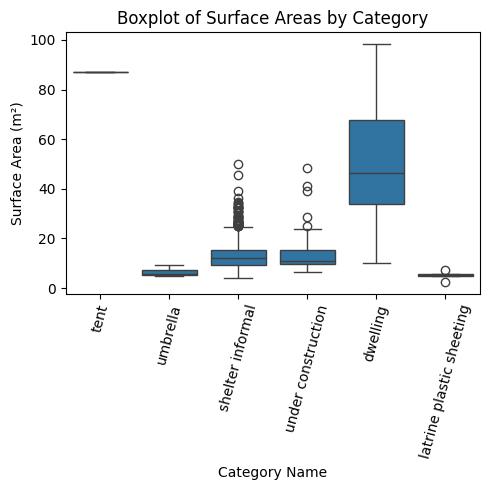

In [23]:
# Plot the surface areas for each category
plt.figure(figsize=(5, 5))
sns.boxplot(x='cat_name', y='area', data=gdf_polygon)

plt.title('Boxplot of Surface Areas by Category')
plt.xlabel('Category Name')
plt.ylabel('Surface Area (m²)')
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

### Non Max Supression
The model is not alway performing well and will give double detection for the same object. With Non Max Supression (NMS) we will try to reduce the number of double detection. More information at https://blog.roboflow.com/how-to-code-non-maximum-suppression-nms-in-plain-numpy/

In [24]:
# Create the list with the specified columns to feed the NMS function
result_list = np.hstack((
    gdf_polygon['bbox'].values.tolist(), 
    gdf_polygon[[ 'cat_id','confidence']].values
)).tolist()

# Add the index to each item in the list to be able to remove detection from the gdf_polygon
result_boxes = [item + [index] for index, item in enumerate(result_list, start=0)]

# Print the number of bboxes in the list
len(result_boxes)

1617

In [25]:
# Apply the Malisiewicz et al. NMS function to our list of bbox
result_nms_boxes = non_max_suppression_fast(result_boxes,0.4)

# Print the number of bboxes in the list
print (f'After NMS : {len(result_nms_boxes)}')

After NMS : 1589


In [26]:
# Extract indices from the result of the NMS
indices = [box[6] for box in result_nms_boxes]

# Filter gdf_polygon by these indices
gdf_polygon = gdf_polygon.iloc[indices]

# Print the gdf size and gdf head
print(gdf_polygon.shape)
gdf_polygon.head()

(1589, 11)


geometry  \
87    POLYGON ((29.12184 -1.61576, 29.12188 -1.61576...   
1637  POLYGON ((29.12239 -1.61555, 29.12243 -1.61555...   
59    POLYGON ((29.12233 -1.61548, 29.12241 -1.61548...   
66    POLYGON ((29.12229 -1.61543, 29.12236 -1.61543...   
20    POLYGON ((29.12298 -1.61544, 29.12306 -1.61544...   

                                                   bbox  \
87    [306.7072448730469, 8415.313110351562, 403.098...   
1637  [1428.4420776367188, 7996.9913330078125, 1503....   
59    [1303.1421585083008, 7856.445556640625, 1470.2...   
66    [1229.3369140625, 7741.082275390625, 1365.7308...   
20    [2638.268798828125, 7763.086669921875, 2793.21...   

                                              bbox_proj  bbox_minx  bbox_miny  \
87    [29.12183745908591, -1.6157603221821892, 29.12...  29.121837  -1.615760   
1637  [29.122388436166272, -1.6155535482375787, 29.1...  29.122388  -1.615554   
59    [29.122326890976094, -1.6154840773035952, 29.1...  29.122327  -1.615484   
66    [29.12229063909471, -1.615427053925853, 29.122...  29.122291  -1.615427   
20    [29.12298268248467, -1.6154379305660433, 29.12...  29.122983  -1.615438   

      bbox_maxx  bbox_maxy  confidence            cat_name  cat_id       area  
87    29.121885  -1.615781    0.537781            dwelling       3  12.342017  
1637  29.122425  -1.615586    0.611877  under construction      13  14.654165  
59    29.122409  -1.615561    0.882987            dwelling       3  78.698345  
66    29.122358  -1.615514    0.863624            dwelling       3  72.262881  
20    29.123059  -1.615501    0.937093            dwelling       3  59.934808

## Plot Count and Confidence by Category

The plots below show that our results have significantly more informal shelters than any other category. The confidence levels for each category are generally low, except for informal shelters. This can be explained by our training dataset, which was primarily created for informal shelters and includes a majority of examples for this category, rather than others.


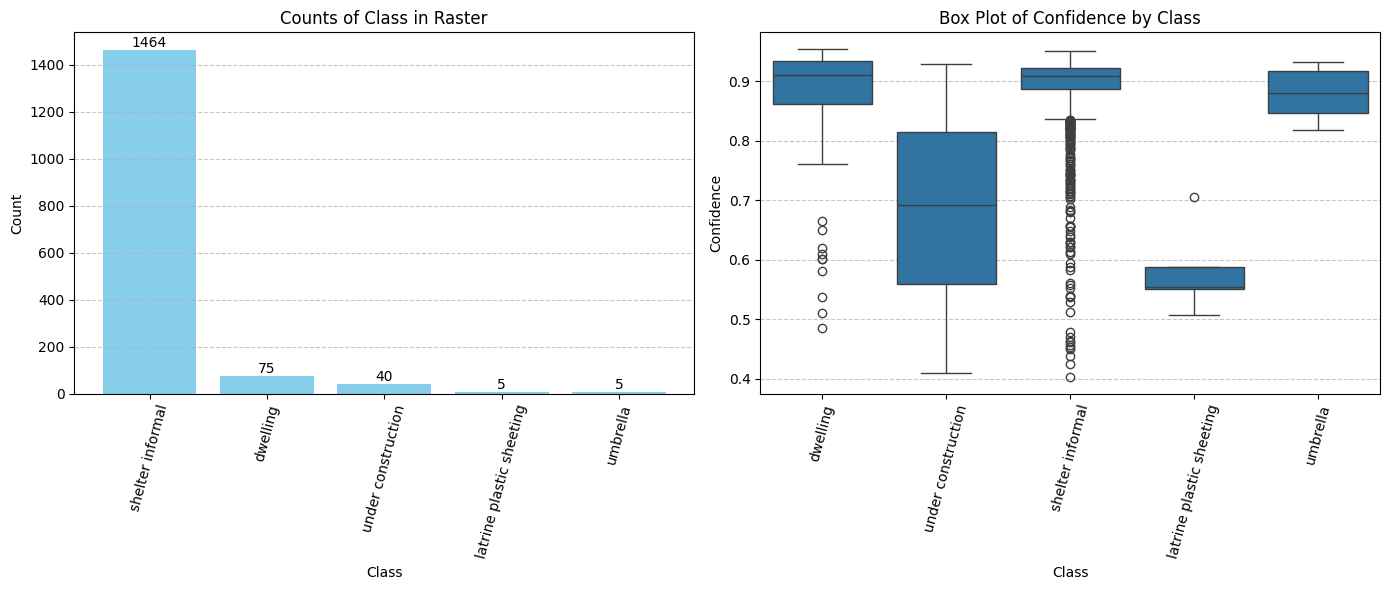

In [27]:
# Create a subplot
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plotting the value counts of class names
value_counts = gdf_polygon['cat_name'].value_counts()
bars = axs[0].bar(value_counts.index, value_counts.values, color='skyblue')

# Adding counts on top of each bar
for bar in bars:
    height = bar.get_height()
    axs[0].text(
        bar.get_x() + bar.get_width() / 2, 
        height, 
        f'{int(height)}', 
        ha='center', 
        va='bottom'
    )

axs[0].set_title('Counts of Class in Raster')
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Count')
axs[0].tick_params(axis='x', rotation=75) 
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# Box plot for confidence
sns.boxplot(x='cat_name', y='confidence', data=gdf_polygon, ax=axs[1])
axs[1].set_title('Box Plot of Confidence by Class')
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Confidence')
axs[1].tick_params(axis='x', rotation=75) 
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Export to .shp
Simply export our gdf to a shapefile in the same forld as our notebook

In [28]:
# Export GeoDataFrame to a shapefile
output_shapefile = "output_detection_camp.shp"
gdf_polygon.drop(['bbox_proj','bbox'], axis=1).to_file(filename=output_shapefile, 
                                                       driver="ESRI Shapefile", 
                                                       crs=EPSG_SOURCE)

## Plot Raster

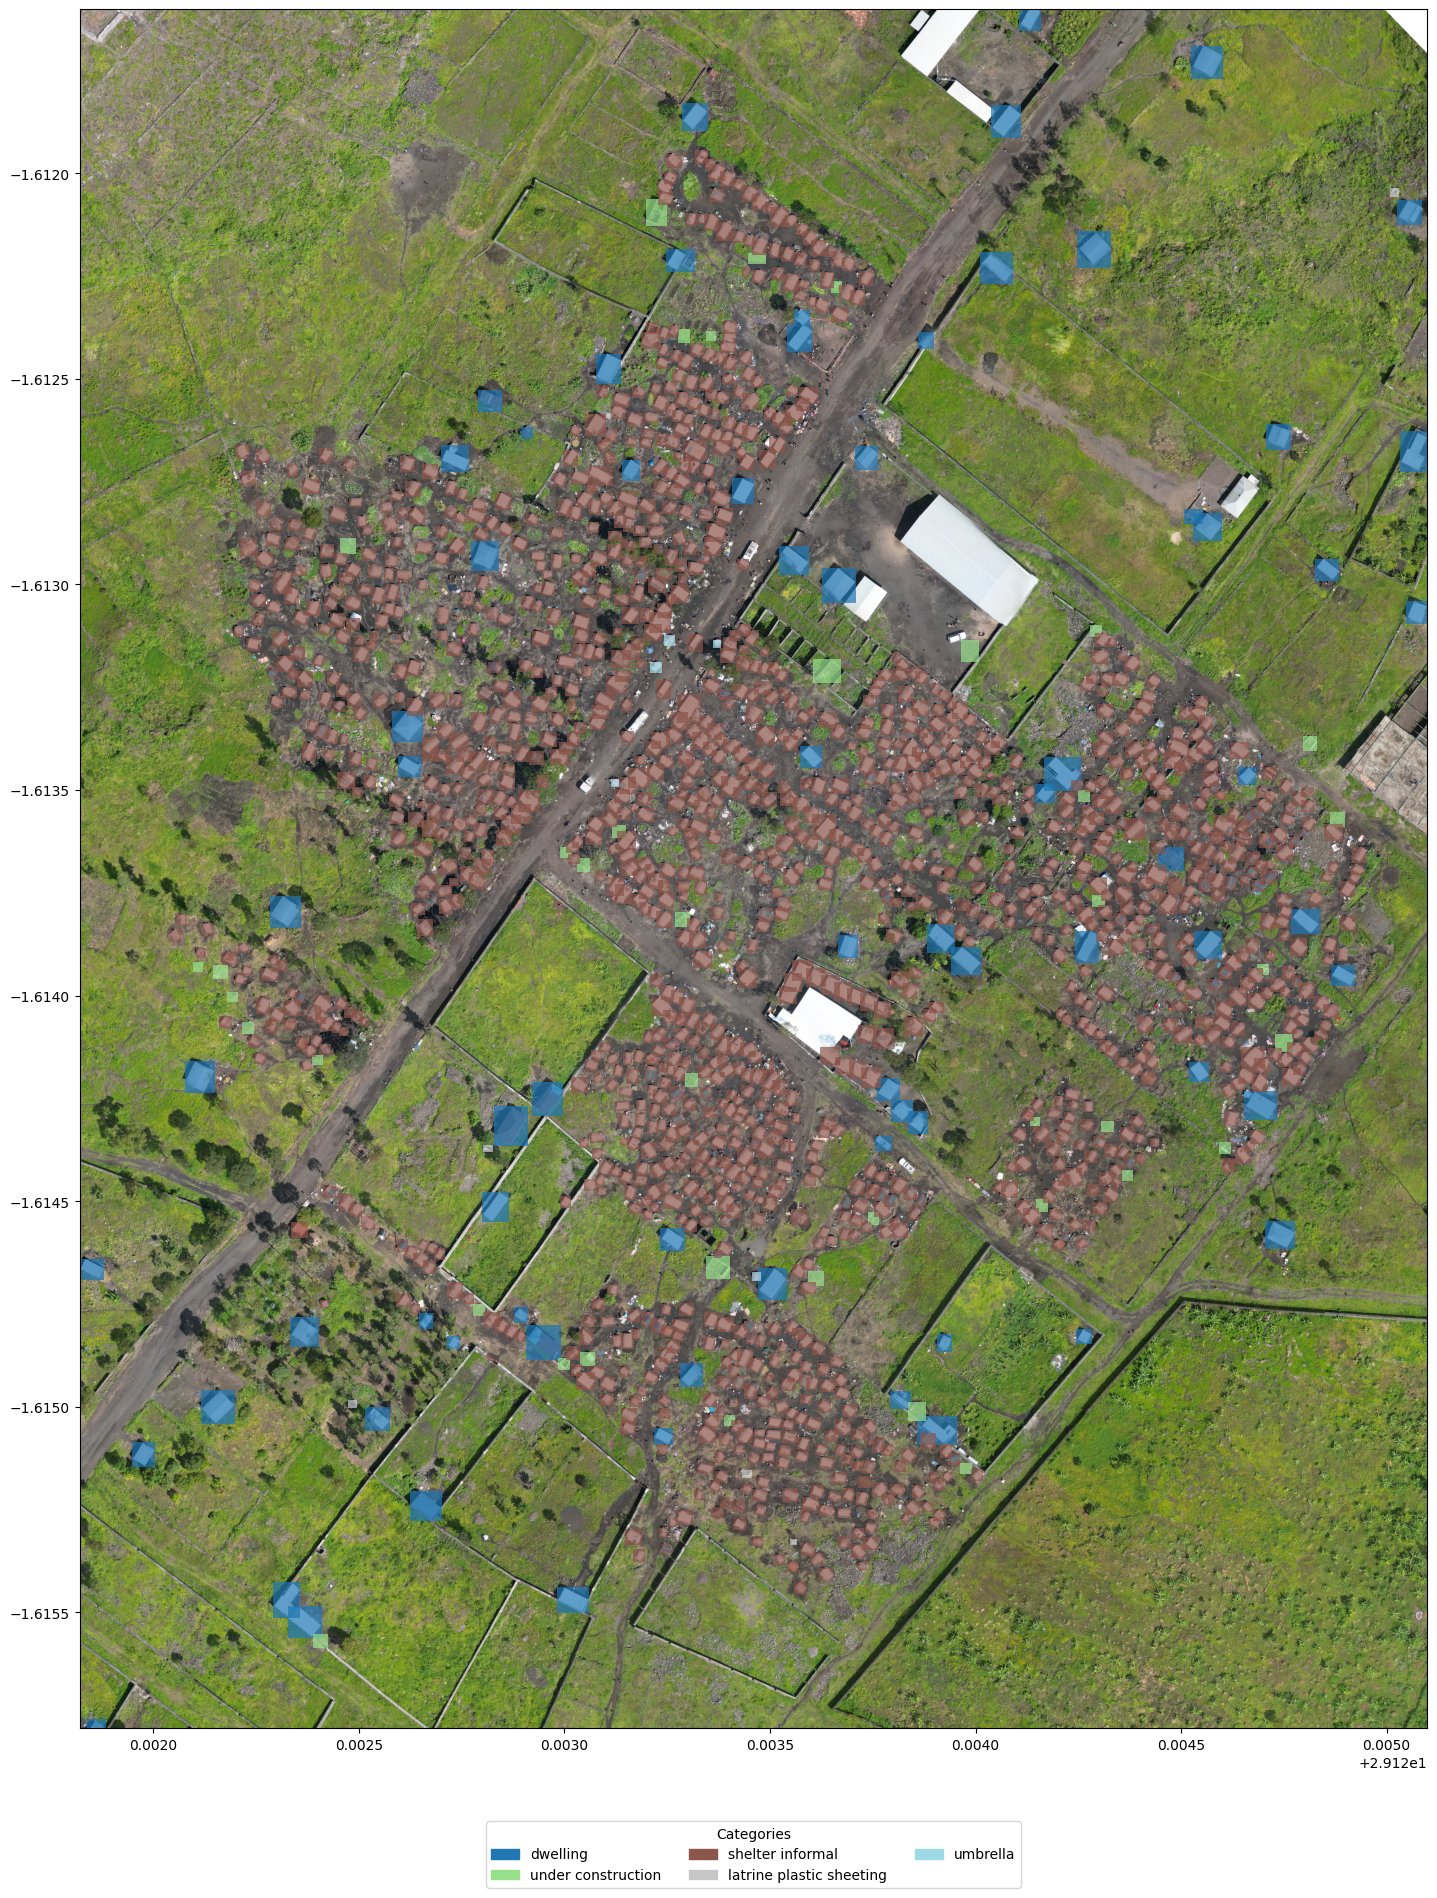

In [29]:
# Plotting code
if plot_raster:
    # Open the GeoTIFF file
    src = rasterio.open(SOURCE_IMAGE_PATH)
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(20, 20))  # Adjust size as needed
    
    # Plot the raster
    show(src, ax=ax)
    
    # Get unique categories and create a colormap
    unique_categories = gdf_polygon['cat_name'].unique()
    cmap = plt.get_cmap('tab20', len(unique_categories)) 
    
    # Create a list to hold legend handles
    handles = []
    
    # Plot each category in the GeoDataFrame with a different color
    for i, category in enumerate(unique_categories):
        subset = gdf_polygon[gdf_polygon['cat_name'] == category]
        color = cmap(i)  # Get a color from the colormap
        subset.plot(ax=ax, color=color, alpha=0.7, label=None)
        
        # Create a patch for each category to add to the legend
        handle = patches.Patch(color=color, label=category)
        handles.append(handle)
    
    # Get the extent of the polygon
    polygon_extent = gdf_polygon.total_bounds
    
    # Set the limits of the axes to focus on the extent of the polygon
    ax.set_xlim([polygon_extent[0], polygon_extent[2]])
    ax.set_ylim([polygon_extent[1], polygon_extent[3]])
    
    # Add a legend below the plot
    ax.legend(handles=handles, title='Categories', bbox_to_anchor=(0.5, -0.05), loc='upper center', ncol=3)
    
    # Adjust layout to make room for the legend
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    # Show the plot
    plt.show()
